# The Intelligent Investor vs Mr.Market
**A case study in validating a Security's Share Price based on comparison of pricing trends vs fundamental and technical data.**

In recent years, a roaring economy and an empowered individual investor have sustained a record-breaking bull market's tenure. The empowerment of the individual investor has largely come from the momentum of the recovering market, but also from an increased access to financial information and agency. As the pool of competitors in the "Fintech" field increases, so does the information and agency at the disposal of the individual investor. However, as this happens, an opposite and potentially equal effect is observed - the amount of misinformation and agency at their disposal, also, increases.

With the newfound volatility in the markets due to political uncertainty, speculation, and geo-political events, the question of discerning whether a security's price is value-justified becomes even more important. That is to say that a security worthy of a long position would be backed by healthy foundational data, and would not be generally correlated to media forecasts, or public speculations.

## Case Study - TDG
For this case study, we'll analyze TransDigm Group (TDG). Having delivered consistent growth for the past 5 years, the company had several major dips in its share price during 2017. The hypothesis we'll interrogate is that these dips, and most major, drastic swings in share price are due to media noise, as opposed to an actual change in a company's value.

## Global Definitions
The security to analyze, along with the date ranges for analysis are defined. A long, and short term period for analysis is defined to optimize computational resources during early research and data exploration.

In [ ]:
# Define Global Vairables
stock_symbol = 'TDG'
asset = symbols(stock_symbol)
analysis_start = '2013-01-01'
analysis_start_short = '2017-01-01'
analysis_end = '2018-04-01'

In [2]:
# Pipeline imports
from quantopian.pipeline.filters import StaticAssets
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.research import prices, returns, symbols

# Fundamental & Technical Data
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.psychsignal import stocktwits, twitter_withretweets

# Computing library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

## Pricing & Returns
Historic pricing & returns data is imported and visualized based on the long-term period defined above. DataFrames are defined for cross referencing to other auxillary data.

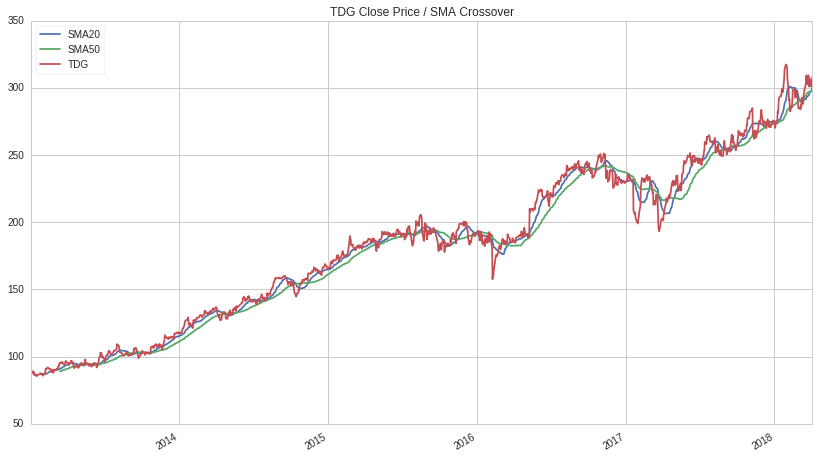

In [3]:
# Query historical pricing data for TDG
tdg_close = prices(assets = asset, start = analysis_start,end = analysis_end,)

# Compute 20 and 50 day moving averages on pricing data
tdg_sma20 = tdg_close.rolling(20).mean()
tdg_sma50 = tdg_close.rolling(50).mean()

# Combine results into a pandas DataFrame and plot
tdg_pricing_dataframe = pd.DataFrame({   
                        stock_symbol: tdg_close,
                        'SMA20': tdg_sma20,
                        'SMA50': tdg_sma50})

# Query returns data for TDG
tdg_returns = returns(assets = symbols(stock_symbol),start = analysis_start,end = analysis_end,)

# Plot pricing data
tdg_pricing_dataframe.plot(title='TDG Close Price / SMA Crossover');

## Define Auxillary Data
In this section, datasets representing human behavioral factors such as preference, sentiment, and communication will be defined so that they may be later correlated to the security's performance, and fundamental data in order to determine whether public opinion, or strong fundamentals is driving share pricing.

Historical fundamental data is pulled from Zipline/Quantopian's API which leverages Morningstar data.  
The technical data is pulled from the Zipline/Quantopian Research API.

The techincal datasets are:
1. Stocktwits Message Volume
2. Stocktwits Sentiment
3. Twitter Message Volume
4. Stocktwits Messave Volume

In [5]:
# Pipeline definition
def make_fundamentals_pipeline():
    
    base_universe  = StaticAssets([asset])
    
    #Fundamentals
    returns = Returns(window_length=2)
    pe_ratio = Fundamentals.pe_ratio.latest
    current_assets = Fundamentals.current_assets.latest
    current_debt = Fundamentals.current_debt.latest
    enterprise_value = Fundamentals.enterprise_value.latest
    eps_earnings = Fundamentals.basic_eps_earnings_reports.latest
    avg_earnings = Fundamentals.basic_average_shares_earnings_reports.latest
    accrued_expenses = Fundamentals.current_accrued_expenses.latest
    current_liabilities = Fundamentals.current_liabilities.latest

    return Pipeline(
        screen = base_universe,
        columns={
            'daily_returns': returns,
            'pe_ratio': pe_ratio,
            'current_assets' : current_assets,
            'current_debt' : current_debt,
            'eps_earnings' : eps_earnings,
            'enterprise_value' : enterprise_value,
            'avg_earnings' : avg_earnings,
            'accrued_exspenses' : accrued_expenses,
            'liabilities' : current_liabilities})

def make_technicals_pipeline():
    
    base_universe  = StaticAssets([asset])
    
    #Technicals
    returns = Returns(window_length=2)
    sentiment_stocktwits = stocktwits.bull_minus_bear.latest
    sentiment_twitter = twitter_withretweets.bull_minus_bear.latest
    msg_volume_stocktwits = stocktwits.total_scanned_messages.latest
    msg_volume_twitter = twitter_withretweets.total_scanned_messages.latest

    return Pipeline(
        screen = base_universe,
        columns={
            'daily_returns': returns,
            'sentiment_stocktwits': sentiment_stocktwits,
            'sentiment_twitter': sentiment_twitter,
            'msg_volume_stocktwits' : msg_volume_stocktwits,
            'msg_volume_twitter' : msg_volume_twitter})

In [6]:
# Technicals Pipeline execution - Short Term
technicals_output = run_pipeline(
    make_technicals_pipeline(),
    start_date = analysis_start_short,
    end_date = analysis_end)

In [7]:
# Fundamentals Pipelien execution - Long Term
fundamentals_output = run_pipeline(
    make_fundamentals_pipeline(),
    start_date = analysis_start,
    end_date = analysis_end)

<string>:5: QuantopianWarning: Morningstar adjusted the calculation for the field 'enterprise_value' starting on April 1, 2018.

The historical values for this field will surface from the vendor in mid-April 2018.

Until the historical data is updated in mid-April, your algorithm will see old (before April 1) and new (after April 1) definitions of the field in the same backtest.
<string>:5: QuantopianWarning: Morningstar adjusted the calculation for the field 'current_accrued_expenses' starting on April 1, 2018.

The historical values for this field will surface from the vendor in mid-April 2018.

Until the historical data is updated in mid-April, your algorithm will see old (before April 1) and new (after April 1) definitions of the field in the same backtest.
<string>:5: QuantopianWarning: Morningstar adjusted the calculation for the field 'current_debt' starting on April 1, 2018.

The historical values for this field will surface from the vendor in mid-April 2018.

Until the histori

## Correlation
In this section, The Pearson Correlation Coefficient (PPMCC) is used to validate the observed plotted and tablulated results. PPMCC or the bivariate correlation, is a measure of the linear correlation between two variables sets of data. The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

### Technical Dataset Comparison
The datasets from media outlets are first compared against each-other to determine any innate preferences, biases, or other correlations between them. Although volume of data/traffic may differ, a comparison of healthy media platforms would suggest a recognition of the same patterns between both - similar sentiment values, changes in message volume, etc.

PPMCC is 0.899228552208
P-Value is 2.08583651667e-114


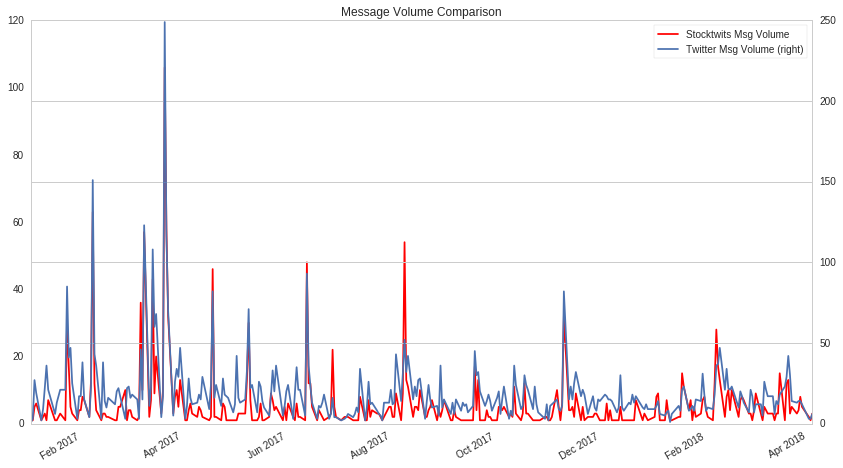

In [19]:
# Define technicals output dataframe
tdg_technical_output = technicals_output.xs(asset,level=1)
#tdg_technical_output.plot(subplots=True);

# Plot message volume to compare between Stocktwits and Twitter Datasets
tdg_technical_output.msg_volume_stocktwits.plot(title='Message Volume Comparison', label='Stocktwits Msg Volume', legend=True, color='Red')
tdg_technical_output.msg_volume_twitter.plot(secondary_y=True, label="Twitter Msg Volume", legend=True)

# Get Pearson Correlation Coefficient
x = tdg_technical_output.msg_volume_stocktwits.values.ravel()
y = tdg_technical_output.msg_volume_twitter.values.ravel()
ppmcc = stats.pearsonr(x, y)

print "PPMCC is {}" .format(ppmcc[0])
print "P-Value is {}" .format(ppmcc[1])

PPMCC is 0.0518660061696
P-Value is 0.358886777617


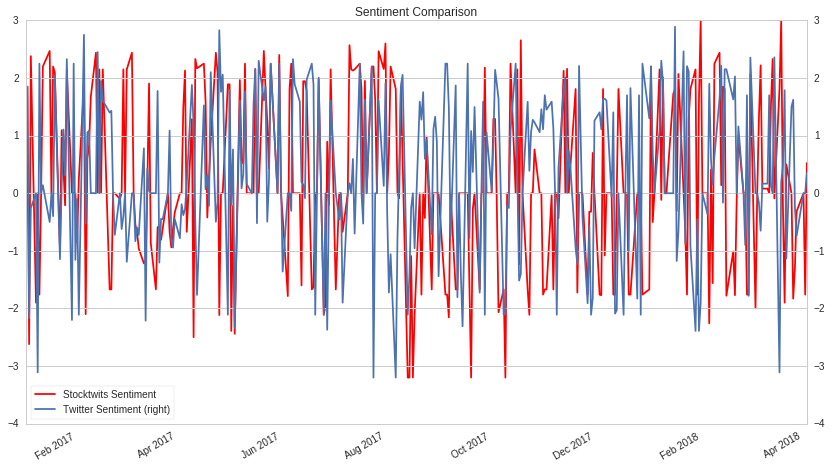

In [20]:
# Plot sentiment data to compare between Stocktwits and Twitter Datasets
tdg_technical_output.sentiment_stocktwits.plot(title='Sentiment Comparison',label='Stocktwits Sentiment', legend=True, color='Red')
tdg_technical_output.sentiment_twitter.plot(secondary_y=True, label="Twitter Sentiment", legend=True)

# Get Pearson Correlation Coefficient
x = tdg_technical_output.sentiment_stocktwits.values.ravel()
y = tdg_technical_output.sentiment_twitter.values.ravel()
ppmcc = stats.pearsonr(x, y)

print "PPMCC is {}" .format(ppmcc[0])
print "P-Value is {}" .format(ppmcc[1])

In [10]:
print tdg_technical_output.sentiment_stocktwits.mean()
print tdg_technical_output.sentiment_twitter.mean()

0.159327507937
0.303631228571


### Takeaways
Based on the the case above, there is a correlation between message volume on both platforms, however there is also a large disparity between user sentiment (twice as high on Twitter vs Stocktwits). This may be due to the userbase demographic of either platform, or an underlying opinionated framework within the platform itself. This suggests that message volume may be a reliable dataset from either platform, but sentiment may not be due to the platform-specific differences previously mentioned.

## Technical Data Correlation to Returns
In this section, we'll look for correlation between media sentiment/message volume, and daily returns. In order to do this, the data will be seperated into two categories - Daily Positive Returns, and Daily Negative Returns. This is done so that we can compare correllation between the datasets in a scalar way, and avoid negative values interfering with the PPMCC computation.

In [11]:
# Define normalization function - remap all values in a dataset between 0 and 1
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# Seperate DataFrames between Positive and Negative daily returns
positive_returns_table = normalize(tdg_technical_output.loc[tdg_technical_output['daily_returns'] > 0])
negative_returns_table = tdg_technical_output.loc[tdg_technical_output['daily_returns'] < 0]

# Take the absolute values of the Negative Returns table
negative_returns_table['daily_returns'] = negative_returns_table['daily_returns'].apply(np.abs)
negative_returns_table = normalize(negative_returns_table)

# Visualisation Options
#negative_returns_table.head()
#positive_returns_table.plot(subplots=True)
#negative_returns_table.plot(subplots=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Positive Returns Analysis

daily_returns Correlation to Returns is 1.0
msg_volume_stocktwits Correlation to Returns is 0.252026263823
msg_volume_twitter Correlation to Returns is 0.3287369751
sentiment_stocktwits Correlation to Returns is 0.0485058255001
sentiment_twitter Correlation to Returns is 0.0662851830162


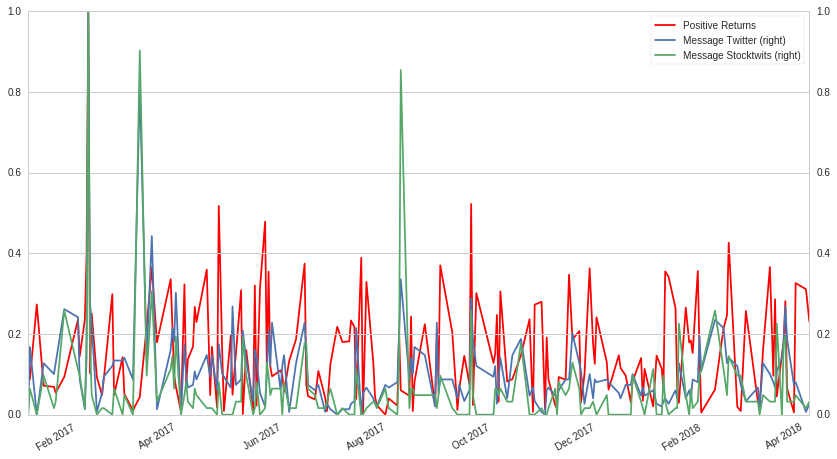

In [12]:
# Plot data
positive_returns_table.daily_returns.plot(label='Positive Returns', legend=True, color='Red')
positive_returns_table.msg_volume_twitter.plot(secondary_y=True, label="Message Twitter", legend=True)
positive_returns_table.msg_volume_stocktwits.plot(secondary_y=True, label="Message Stocktwits", legend=True)

# Get Pearson Correlation Coefficient
x = positive_returns_table.daily_returns.values.ravel()
for column in positive_returns_table:
    y = positive_returns_table[column].values.ravel()
    pmc = stats.pearsonr(x, y)
    print "{} Correlation to Returns is {}".format(column, pmc[0])

### Negative Returns Analysis

daily_returns Correlation to Returns is 1.0
msg_volume_stocktwits Correlation to Returns is 0.453609697612
msg_volume_twitter Correlation to Returns is 0.444876471514
sentiment_stocktwits Correlation to Returns is -0.196480553578
sentiment_twitter Correlation to Returns is -0.0905081005726


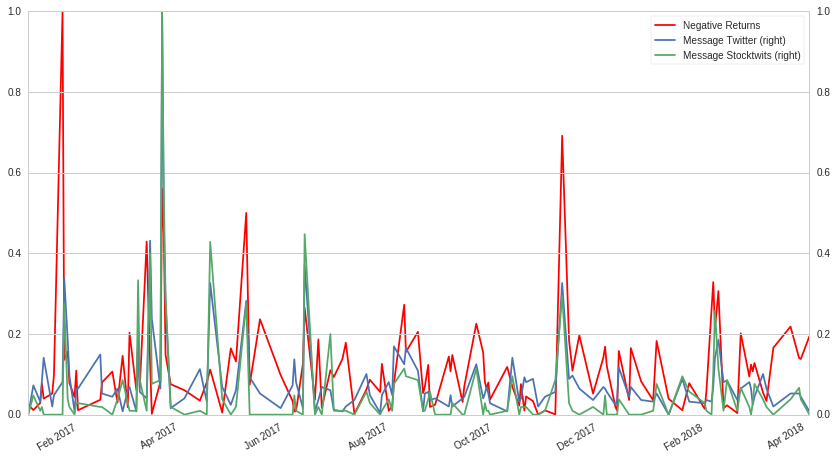

In [13]:
negative_returns_table.daily_returns.plot(label='Negative Returns', legend=True, color='Red')
negative_returns_table.msg_volume_twitter.plot(secondary_y=True, label="Message Twitter", legend=True)
negative_returns_table.msg_volume_stocktwits.plot(secondary_y=True, label="Message Stocktwits", legend=True)

# Get Pearson Correlation Coefficient
x = negative_returns_table.daily_returns.values.ravel()
for column in negative_returns_table:
    y = negative_returns_table[column].values.ravel()
    pmc = stats.pearsonr(x, y)
    print "{} Correlation to Returns is {}".format(column, pmc[0])

### Takeaways
In this case, message volume is much more strongly correlated to negative daily returns, than positive daily returns. Sentiment is found to have little to no correlation. This would suggest that media traffic/volume has a stronger negative effect, and that the specifics of the media message have little to no effect.

### Final Technical Validation
We can take this investigation even further by looking at the single worst days for stock price, and correlating them to that day's media data. If there is a strong correlation, it would suggest that the most severe drops in share price are due to media volume and public opinion, rather than tangible changes in the security's value.

daily_returns Correlation to Returns is 1.0
msg_volume_stocktwits Correlation to Returns is 0.374539278037
msg_volume_twitter Correlation to Returns is 0.424828160643
sentiment_stocktwits Correlation to Returns is -0.117366482754
sentiment_twitter Correlation to Returns is -0.0505821471743

Analyzing Top 25.0% Largest Negative Daily Swings


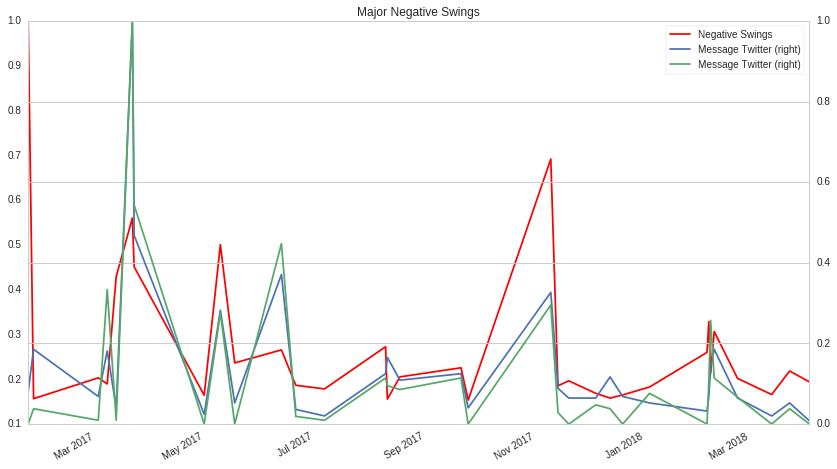

In [55]:
# Create dataframe containing largest single day negative swings in stock price/returns
large_negative_swings = negative_returns_table.loc[negative_returns_table['daily_returns'] > 0.15]

# Plot negative swings vs media message volume
large_negative_swings.daily_returns.plot(title='Major Negative Swings', label='Negative Swings', legend=True, color='Red')
large_negative_swings.msg_volume_twitter.plot(secondary_y=True, label="Message Twitter", legend=True)
large_negative_swings.msg_volume_stocktwits.plot(secondary_y=True, label="Message Twitter", legend=True)

# Get Pearson Correlation Coefficient
x = large_negative_swings.daily_returns.values.ravel()
for column in large_negative_swings:
    y = large_negative_swings[column].values.ravel()
    pmc = stats.pearsonr(x, y)
    print "{} Correlation to Returns is {}".format(column, pmc[0])

# Ouptut top x% of worst daily swings taken into account
a = float(len(large_negative_swings))
b = float(len(negative_returns_table))
print ""; print "Analyzing Top {}% Largest Negative Daily Swings".format((a/b)*100)

### Takeaways
In this case, when analyzing the top 25% worst days for holding the security, there is a strong apparent correlation to media message volume. It is only marginally lower than the correlation between the full dataset (100% of all negative days) and secuirty price.

## Fundamentals

The analysis in this section is based on the following principles:
1. **Over-Valued** - Share Price grows faster than a company's valuation. Perhaps based on public opinion, political shifts, or other forms of speculation.
2. **Correctly-Valued** - Share Price correlates with a company's Enterprise Value.
3. **Under-Valued** - Share Price is [TBD]

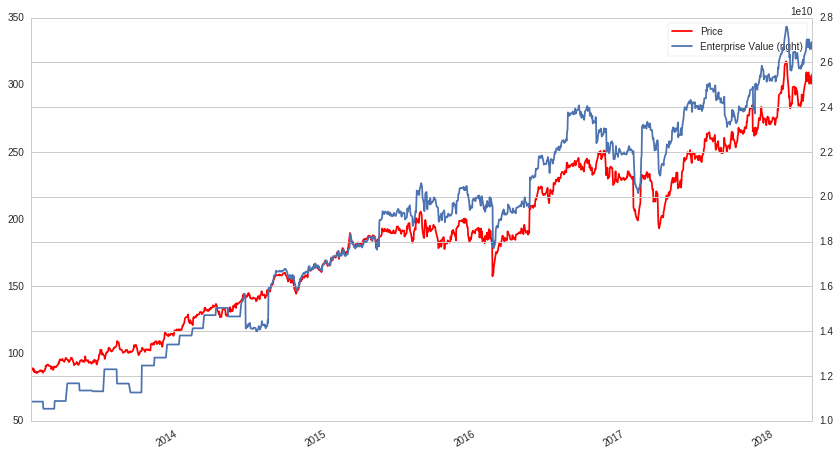

In [15]:
# Define fundamentals output dataframe
tdg_fundamentals_output = fundamentals_output.xs(asset,level=1)

# Plot pricing vs Enterprise Value to compare trends
tdg_pricing_dataframe.TDG.plot(label='Price', legend=True, color='Red')
tdg_fundamentals_output.enterprise_value.plot(secondary_y=True, label="Enterprise Value", legend=True)

In [16]:
x = tdg_pricing_dataframe.TDG
x = x.values.ravel()
y = tdg_fundamentals_output.enterprise_value
y = y.values.ravel()[:-1]

ppmcc = stats.pearsonr(x, y)
print "PPMCC is {}" .format(ppmcc[0])
print "P-Value is {}" .format(ppmcc[1])

ValueError: operands could not be broadcast together with shapes (1323,) (1322,) 